In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.00])
    plt.xlim([0.0, 1.00])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

In [3]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [4]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}

dic1 = {'Yes':1,'No':0}

dic2 = {'In State':1,'Out of State':0}

dic3 = {'Owner':1,'1st Gen':0}

dic4 = {'Couple':1,'Single':0}

dic5 = {'Weekday':0, 'Weekend':1}

dic6 = {2017:0,2018:1}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)

df['Homeowner']=df['Homeowner'].replace(dic1)

df['InState']=df['InState'].replace(dic2)

df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)

df['relationStatus']=df['relationStatus'].replace(dic4)

df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)

df['Year of TourDate']=df['Year of TourDate'].replace(dic6)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15932 entries, 146456 to 385472
Data columns (total 17 columns):
?TourContractGeneration       15932 non-null int64
?TourGeneration               15932 non-null int64
Age                           15932 non-null int64
AgentLine                     15932 non-null object
BookingWindow                 15932 non-null object
FirstGenVsOwner               15932 non-null int64
HHIncomeRanges                15932 non-null object
Homeowner                     15932 non-null int64
InState                       15932 non-null int64
Month of TourDate             15932 non-null object
Programs (Budget)             15932 non-null object
relationStatus                15932 non-null int64
ResultOfTour                  15932 non-null int64
TourSeason                    15932 non-null object
WeekdayOrWeekend              15932 non-null int64
Year of TourDate              15932 non-null int64
NetVolumePlusNonGoodVolume    15932 non-null float64
dtypes: fl

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek


dfX = df.drop(['ResultOfTour',   'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=['AgentLine','BookingWindow',
       'HHIncomeRanges', 'Month of TourDate', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])


scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])
       

X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)




dfX1 = X_train
dfY1 = y_train


# define resampling method
resample = SMOTETomek(random_state=42, ratio = 'minority')

dfX2, dfY2 = resample.fit_sample(dfX1, dfY1)
dfX2= pd.DataFrame(dfX2, columns = dfX.columns)
dfY2= pd.DataFrame(dfY2)

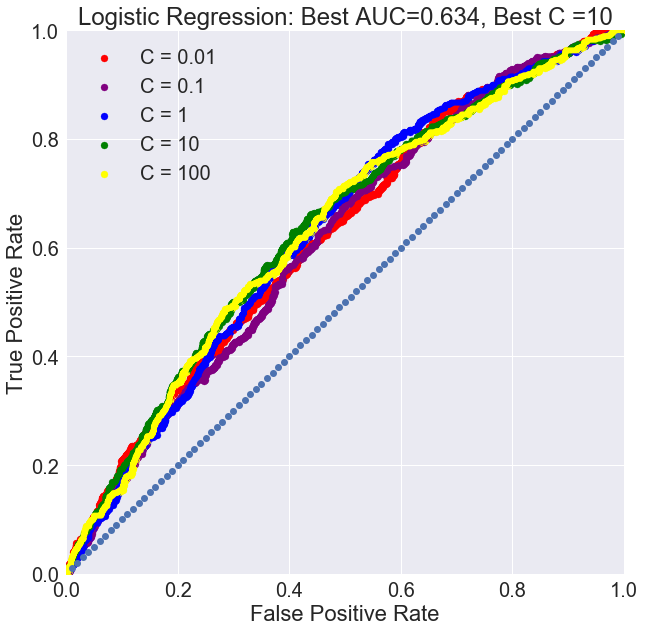

In [6]:


bestC = 0
bestAUCC = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,100]
kf = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    lr = LogisticRegression(C=Cs[i])
    lr.fit(xTrain,yTrain)
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCC:
        bestC=Cs[i]
        bestAUCC=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='C = '+str(Cs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('Logistic Regression: Best AUC='+str(round(bestAUCC,3))+', Best C ='+str(bestC))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

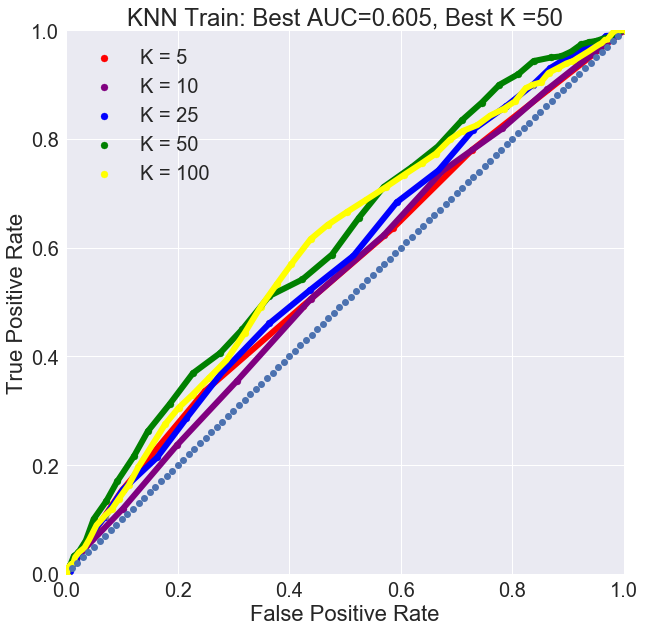

In [7]:
from sklearn.neighbors import KNeighborsClassifier


bestK = 0
bestAUCK = 0
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ks = [5,10,25,50,100]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)

#create oversampler

#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    knn = KNeighborsClassifier(Ks[i])
    knn.fit( xTrain , yTrain)
    preds = knn.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCK:
        bestK=Ks[i]
        bestAUCK=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='K = '+str(Ks[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('KNN Train: Best AUC='+str(round(bestAUCK,3))+', Best K ='+str(bestK))
plt.plot(x,y,'o')
plt.show()


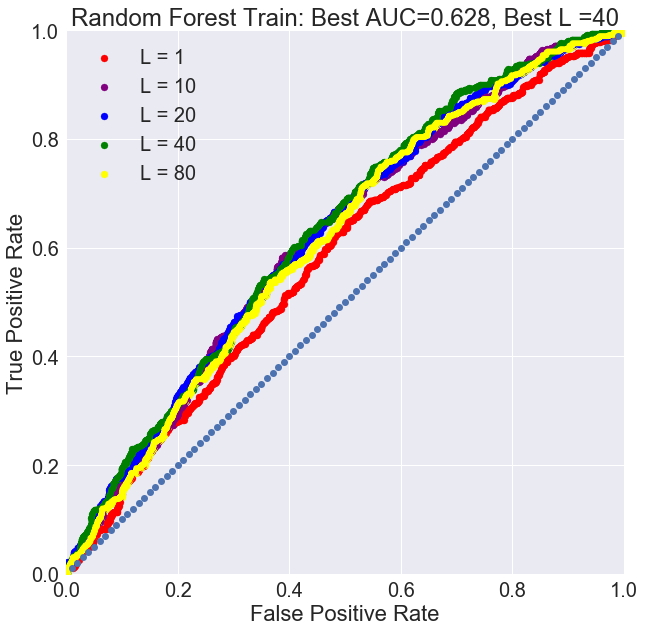

In [8]:
from sklearn.ensemble import RandomForestClassifier

bestL = 0
bestAUCL = 0
bestFeatureImportances= []
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ls = [1,10,20,40,80]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    rfr = RandomForestClassifier(n_estimators=1000,min_samples_leaf=Ls[i], random_state=42)
    rfr.fit(xTrain,yTrain)
    preds = rfr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCL:
        bestL=Ls[i]
        bestAUCL=auc
        bestFeatureImportances = rfr.feature_importances_
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='L = '+str(Ls[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('Random Forest Train: Best AUC='+str(round(bestAUCL,3))+', Best L ='+str(bestL))
plt.plot(x,y,'o')
plt.show()

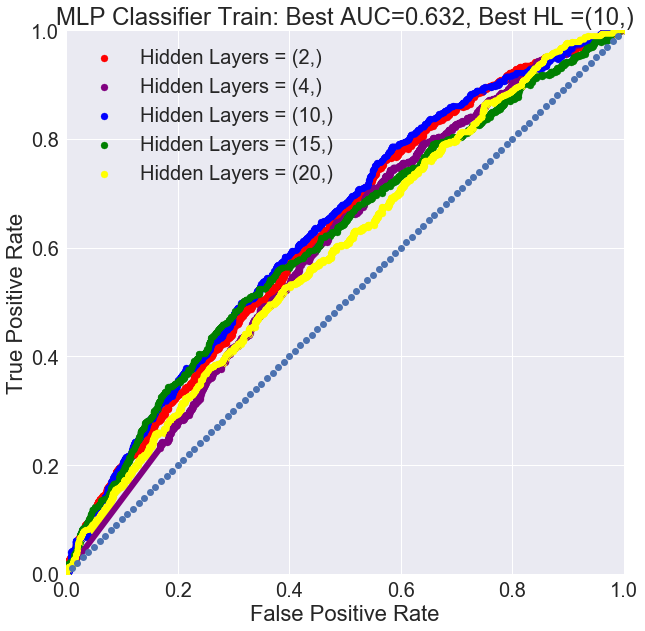

In [9]:
from sklearn.neural_network import MLPClassifier
import itertools 

bestHL = 0
bestAUCHL = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
HLs= [x for x in itertools.product((2,4,10,15,20),repeat=1)]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    xTrain = dfX1.iloc[train.tolist()]
    yTrain = dfY1.iloc[train.tolist()]
    xTrain, yTrain = resample.fit_sample(xTrain,yTrain)
    lr = MLPClassifier(hidden_layer_sizes=HLs[i])
    lr.fit(xTrain,yTrain)
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCHL:
        bestHL=HLs[i]
        bestAUCHL=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='Hidden Layers = '+str(HLs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.title('MLP Classifier Train: Best AUC='+str(round(bestAUCHL,3))+', Best HL ='+str(bestHL))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please c

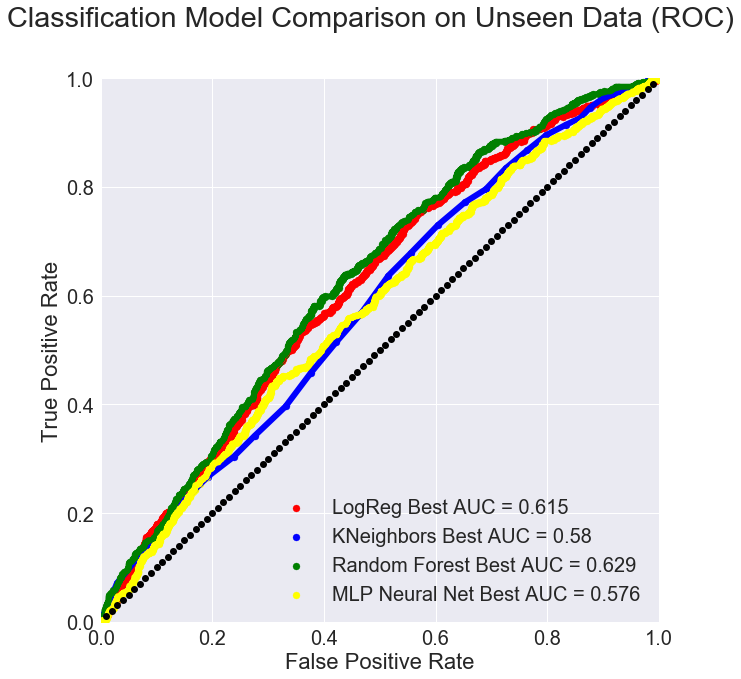

In [10]:
#logistic regregression best model 
lr = LogisticRegression(C=bestC)
lr.fit(dfX2,dfY2)
preds = lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=fpr, y=tpr, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Red',linewidth=6.0)


#knn best model 
knn = KNeighborsClassifier(bestK)
knn.fit(dfX2,dfY2)
preds = knn.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Blue', label= 'KNeighbors Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Blue',linewidth=6.0)

#random forest best model 
rf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42)
rf.fit(dfX2,dfY2)
preds = rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Green',linewidth=6.0)

# Neural Net MLPClassifier
clf = MLPClassifier()
clf.fit(dfX2,dfY2)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Yellow', label= 'MLP Neural Net Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Yellow',linewidth=6.0)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(x,y,'o', color='Black')
plt.suptitle('Classification Model Comparison on Unseen Data (ROC)')
plt.show()

     pred_neg  pred_pos
neg       922      1692
pos       114       459


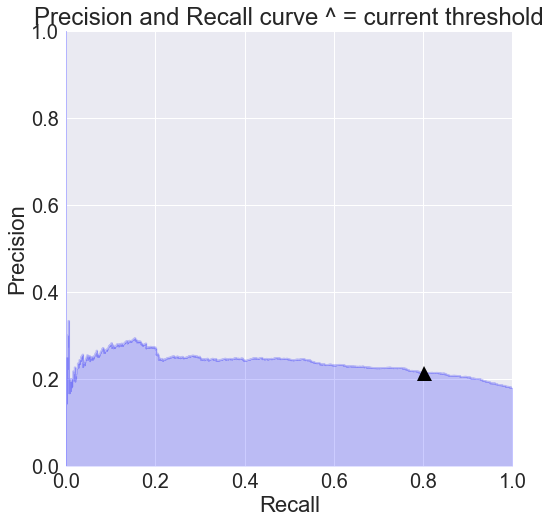

In [11]:
#
y_scores = lr.predict_proba(X_test)[:,1]
p,r,thresholds = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(p, r, thresholds,0.4)


     pred_neg  pred_pos
neg       434      2180
pos        49       524


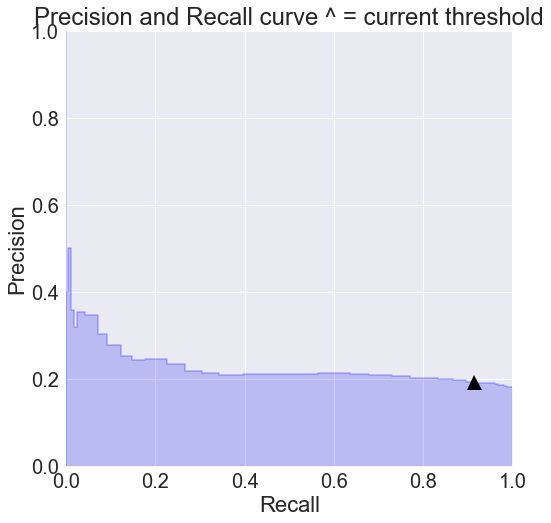

In [12]:

#
y_scores = knn.predict_proba(X_test)[:,1]
p,r,thresholds = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(p, r, thresholds,0.4)



     pred_neg  pred_pos
neg       820      1794
pos        76       497


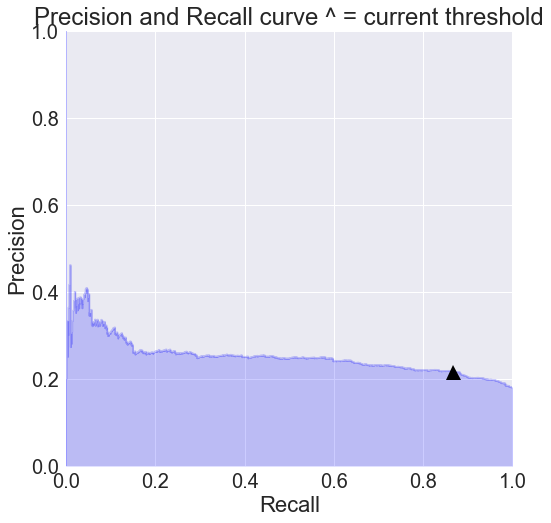

In [13]:
#
y_scores = rf.predict_proba(X_test)[:,1]
p,r,thresholds = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(p, r, thresholds,0.31)


     pred_neg  pred_pos
neg      1641       973
pos       303       270


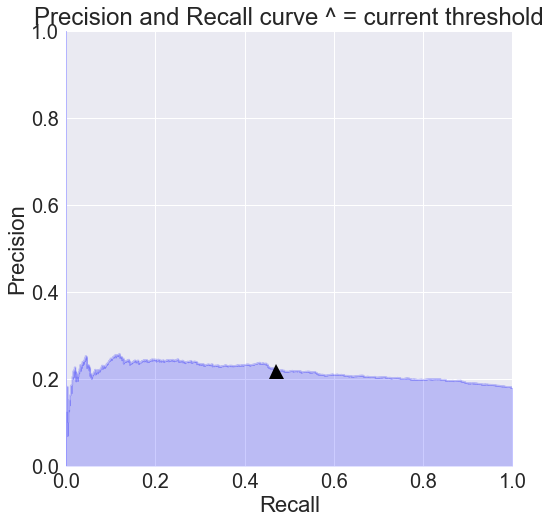

In [14]:

#
y_scores = clf.predict_proba(X_test)[:,1]
p,r,thresholds = precision_recall_curve(y_test,y_scores)
precision_recall_threshold(p, r, thresholds,0.2)

In [15]:
print('Random Forest Feature Importances:')
print()
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(round(x,3),y)

Random Forest Feature Importances:

0.1 InState
0.087 ?TourGeneration
0.081 WeekdayOrWeekend
0.066 HHIncomeRanges_70k to 89k
0.06 relationStatus
0.059 ?TourContractGeneration
0.05 Age
0.041 HHIncomeRanges_90k to 149k
0.037 HHIncomeRanges_150k to 199k
0.031 BookingWindow_Inside 90 days
0.025 FirstGenVsOwner
0.023 Year of TourDate
0.022 Programs (Budget)_(09) GL7 Inhouse
0.022 BookingWindow_Inside Month
0.021 AgentLine_Colorado
0.02 Programs (Budget)_(12) Outbound Telemarktng
0.017 HHIncomeRanges_Under 70k
0.017 HHIncomeRanges_200k to 349k
0.017 AgentLine_Breck
0.014 BookingWindow_Inside 2 Days
0.014 BookingWindow_Inside Half Year
0.013 Homeowner
0.012 BookingWindow_Inside Year
0.012 HHIncomeRanges_350k to 500k
0.012 Programs (Budget)_(06) GC8 Inhouse
0.011 AgentLine_Other Line
0.011 BookingWindow_Inside Week
0.008 Programs (Budget)_(21) GTL In House
0.008 Programs (Budget)_(14) Summit County OPC
0.007 Programs (Budget)_(17) Guest Member
0.007 HHIncomeRanges_Over 500k
0.007 Programs (Bud